In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import librosa
import os
import time
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import pandas as pd
import librosa
import simpleaudio as sa
import math
from IPython import display
import warnings

import matplotlib.colors as colors
from scipy.io import wavfile
import librosa.display
import numpy as np
from numpy.linalg import pinv, inv, solve, lstsq
import simpleaudio as sa

C:\Users\1002983\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
# Converting into spectrograms
# Spectrograms are stored as spectrograms.tfrecord
nsynth = tf.data.TFRecordDataset("C:/Users/1002983/Documents/machine-learning-tone-generation/project/nsynth-test.tfrecord")
i = 1
numTrue = 0
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'audio': tf.VarLenFeature(dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}
i = 0
j = 0
for b in nsynth:
    i += 1
    data = tf.parse_single_example(serialized=b, features=read_features)
    print(i, end='\r')
    if(data['instrument_source'].numpy()==0 and data['instrument_family'].numpy()==7):
        if(j < 50):
            j += 1
            continue
        audio = data['audio'].values.numpy()*15000
        audio = np.array(audio)
        spectrogram = librosa.stft(audio, 2048)

        magnitudes = np.log(np.abs(spectrogram) + 1.2664166e-14).reshape(1025, 126, 1)
        phases = np.angle(spectrogram).reshape(1025, 126, 1)
        phases = phases / (math.pi)
        magnitudes = 2*(magnitudes+32)/(16+32)-1
        spec = np.concatenate([magnitudes, phases], 2)
        print(data['instrument_str'])
        break

print("\nDone")

tf.Tensor(b'reed_acoustic_037', shape=(), dtype=string)

Done


In [29]:
def audioFigs(filename, figure_name, audio, sr, seconds_interval=1, scaling=True, playBack=False, seconds=None):
    if(len(audio.shape) == 2): 
        audio = audio[:, 0]
    if(seconds != None):
        audio = audio[0:int(seconds*sr)]
    if(scaling):
        audio = audio / np.amax([np.amax(audio), -1*np.amin(audio)]) * 15000
    spectrogram = librosa.stft(audio, 2048)
    magnitudes = np.log(np.abs(spectrogram) + 1.2664166e-14)
    phases = np.angle(spectrogram) / math.pi
    if(sr==16000):
        num_ticks = 4
    elif(sr==44100):
        num_ticks = 5
    else:
        warnings.warn("Sample rate of {} unfamiliar, please add test condition".format(sr))
        num_ticks = 4

    plt.figure(0)
    plt.plot(np.arange(0, audio.size/sr, 1/sr)[:audio.size], audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Samples")
    plt.title("{}: raw audio".format(figure_name))
    plt.ylim(-15000, 15000)
    plt.xlim(0, audio.size/sr)
    plt.yticks(np.arange(-15000, 15001, 5000))
    plt.savefig("{}-raw.png".format(filename))
    
    basis = librosa.fft_frequencies(sr=sr, n_fft=(2 * (magnitudes.shape[0]-1)))
    fmax = basis[-1]
    basis -= 0.5 * (basis[1] - basis[0])
    basis = np.append(np.maximum(0, basis), [fmax])
    fmax = np.amax(basis)
    
    plt.figure(1)
    plt.imshow(magnitudes, cmap="magma", origin="lower", aspect="auto", extent=[0, magnitudes.shape[1], 0, magnitudes.shape[0]])
    plt.title("{}: Spectrogram (magnitudes)".format(figure_name))
    plt.yticks(np.arange(0, magnitudes.shape[0]+1, magnitudes.shape[0]/num_ticks), np.arange(0, int(fmax+1), int(fmax/num_ticks)))
    plt.xticks(np.arange(0, magnitudes.shape[1]+1, magnitudes.shape[1]*seconds_interval/int(len(audio)/sr)), np.arange(0, len(audio)/sr+0.0001, seconds_interval))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.savefig("{}-mag.png".format(filename))
               
    plt.figure(2)
    plt.imshow(phases, cmap="hsv", origin="lower", aspect="auto", extent=[0, magnitudes.shape[1], 0, magnitudes.shape[0]])
    plt.title("{}: Spectrogram (phases)".format(figure_name))
    plt.yticks(np.arange(0, magnitudes.shape[0]+1, magnitudes.shape[0]/num_ticks), np.arange(0, int(fmax+1), int(fmax/num_ticks)))
    plt.xticks(np.arange(0, magnitudes.shape[1]+1, magnitudes.shape[1]*seconds_interval/int(len(audio)/sr)), np.arange(0, len(audio)/sr+0.0001, seconds_interval))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.savefig("{}-ang.png".format(filename))
    
    if(scaling):
        wavfile.write("{}-scaled.wav".format(filename), sr, audio.astype(np.int16))
    if(playBack):
        sr, audio = wavfile.read("{}-scaled.wav".format(filename))
        playAudio(audio, sr)
        
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

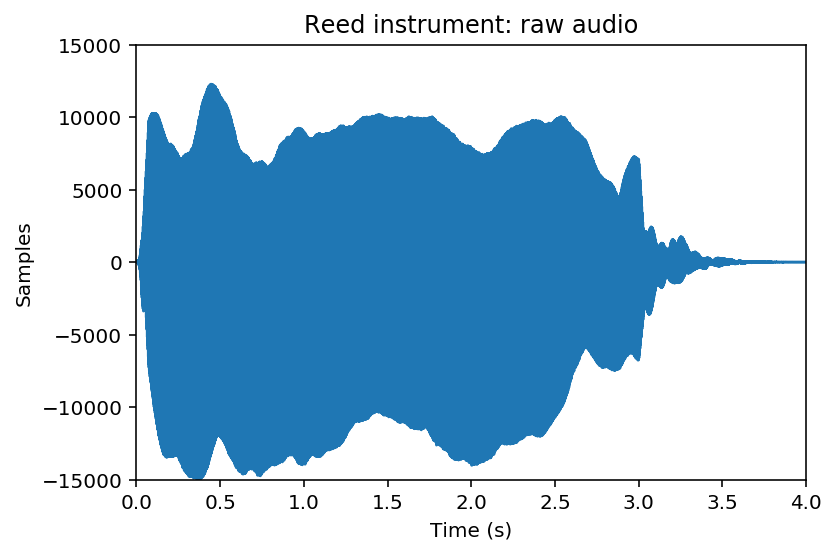

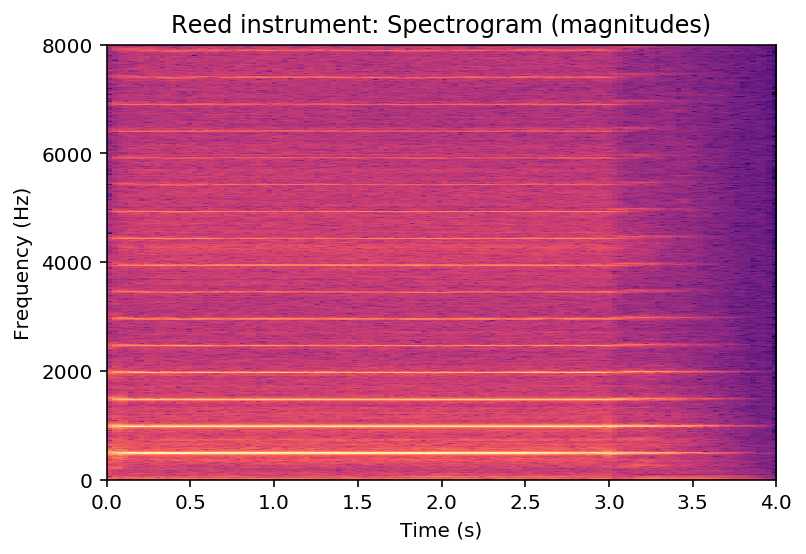

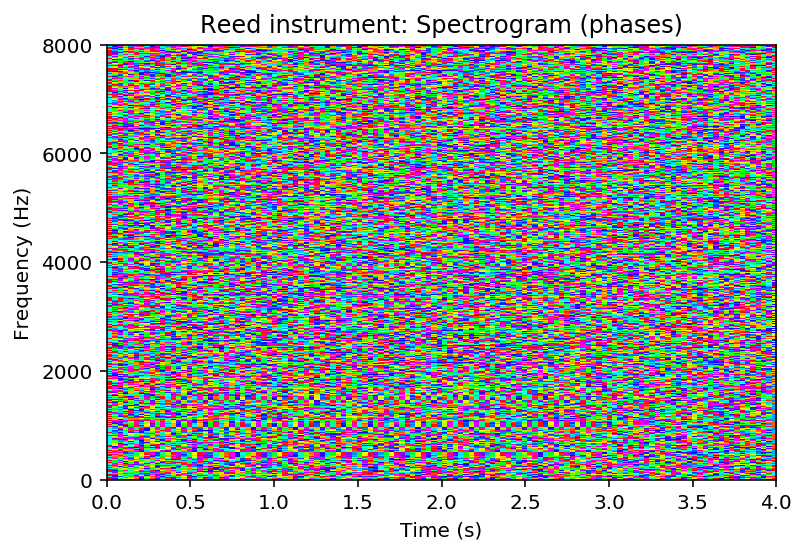

In [30]:
audioFigs("Reed instrument", "Reed instrument", audio, 16000, 0.5, playBack=True)


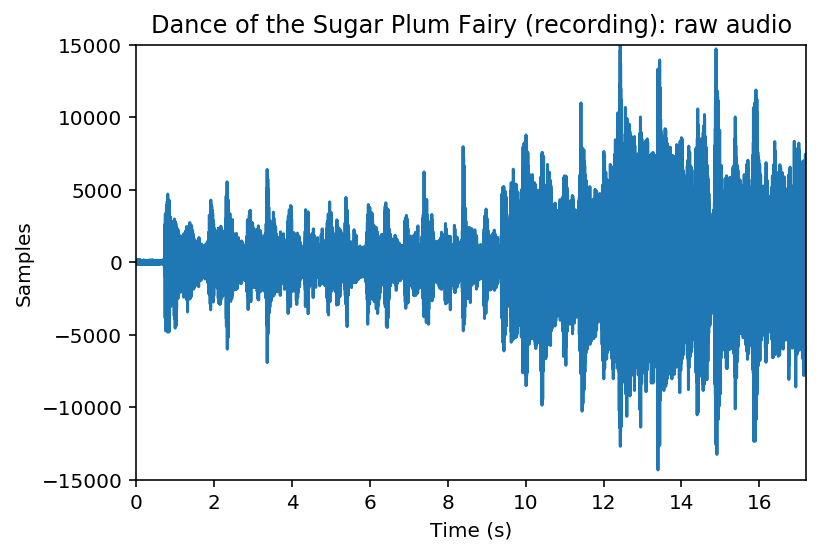

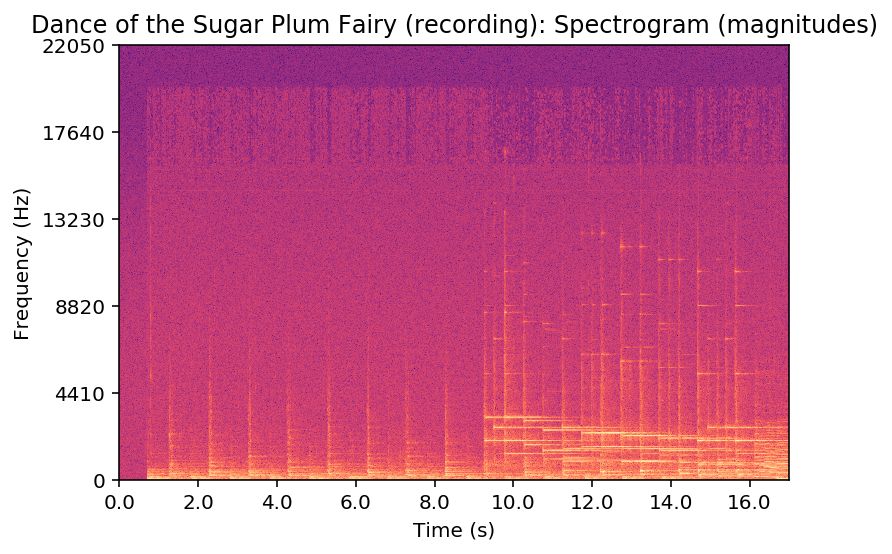

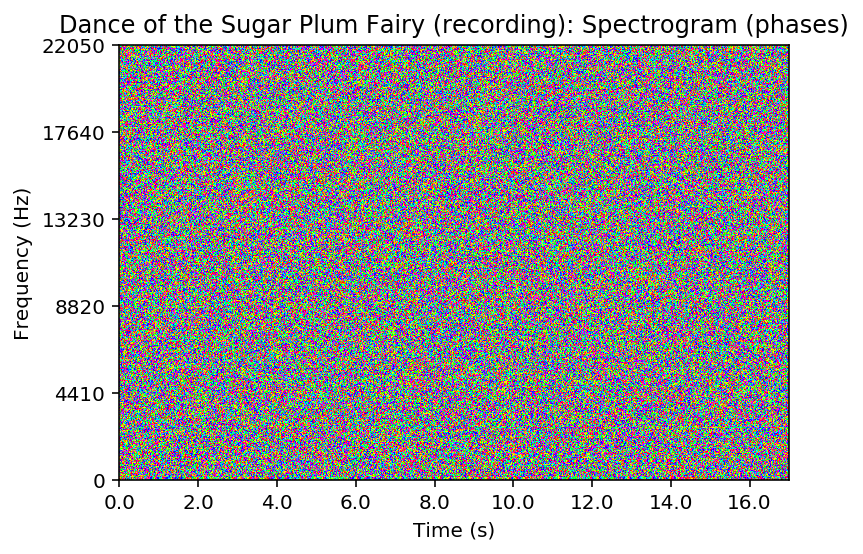

In [31]:
dance_sr, dance_audio = wavfile.read('real.wav')
audioFigs("dance", "Dance of the Sugar Plum Fairy (recording)", dance_audio, dance_sr, 2, playBack=True, seconds=17.2)

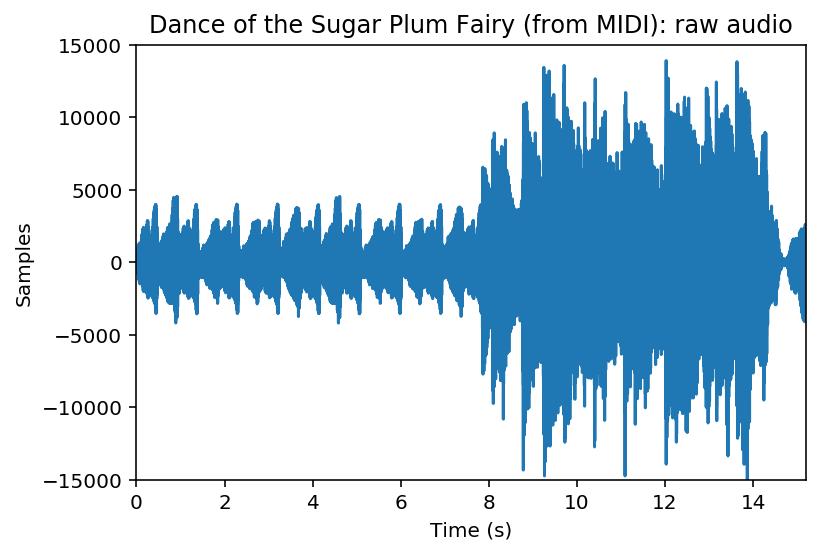

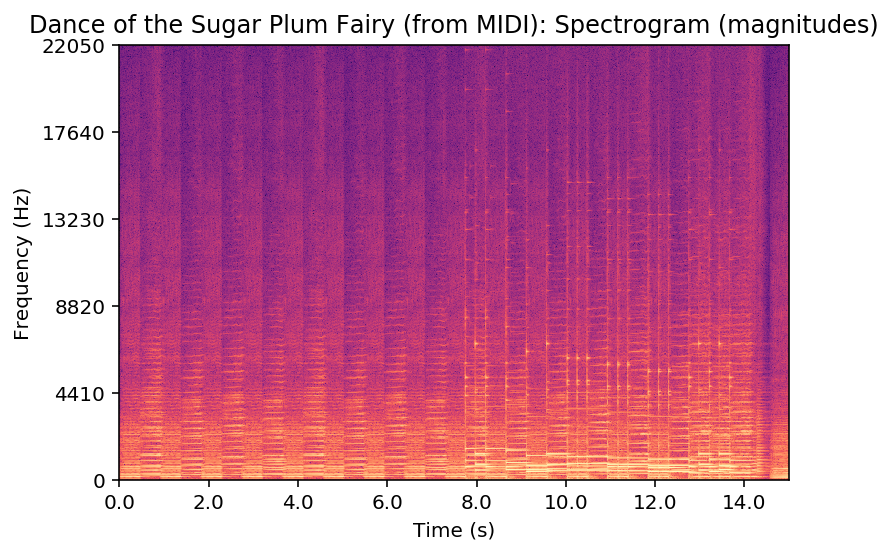

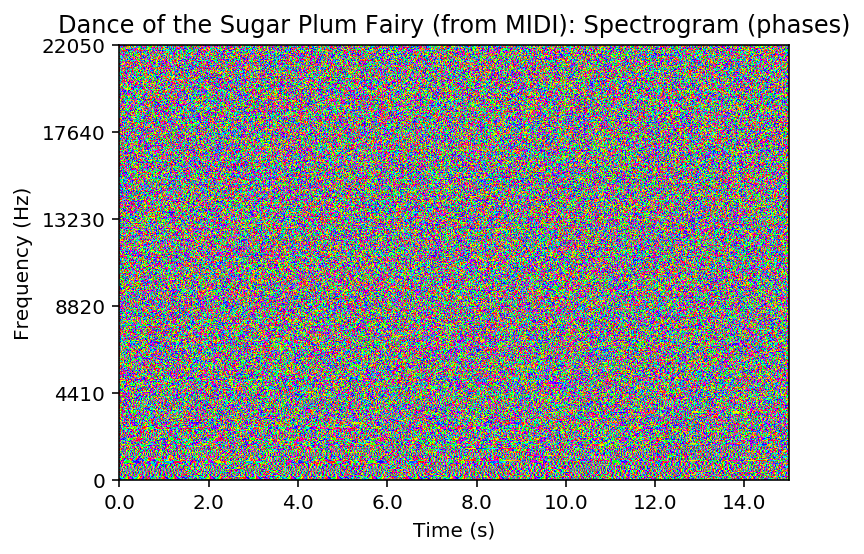

In [35]:
midi_audio, midi_sr = librosa.load('from-midi.wav', sr=None)
audioFigs("midi", "Dance of the Sugar Plum Fairy (from MIDI)", midi_audio, midi_sr, 2, playBack=True, seconds=15.2)

Running
Unpacked wav file


C:\Users\1002983\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\display.py:665: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


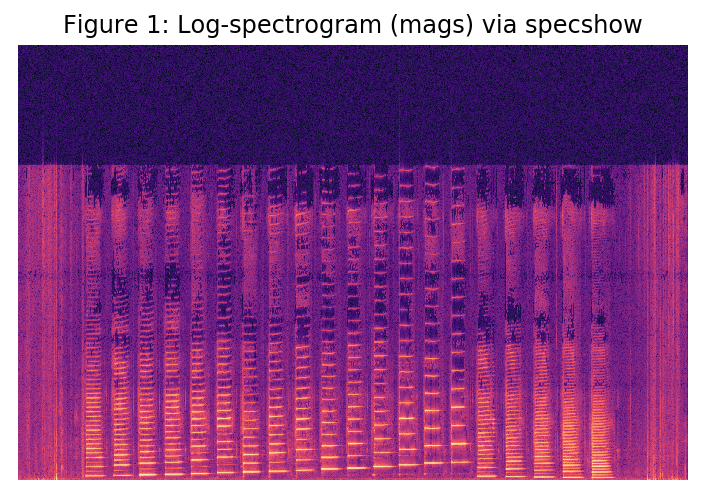

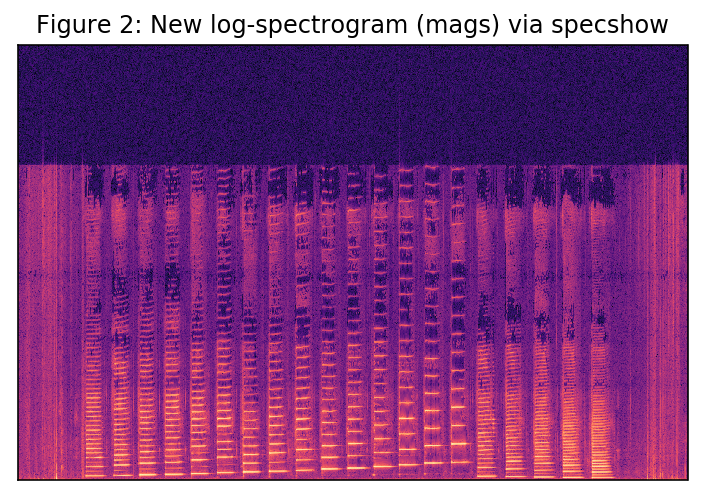

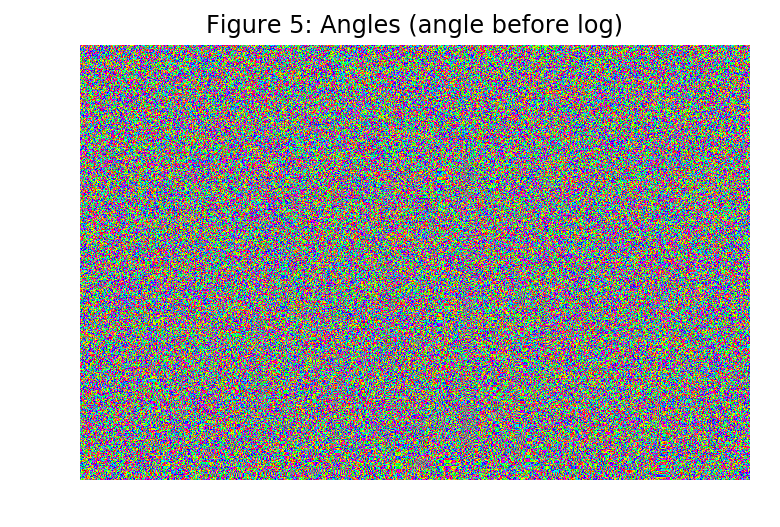

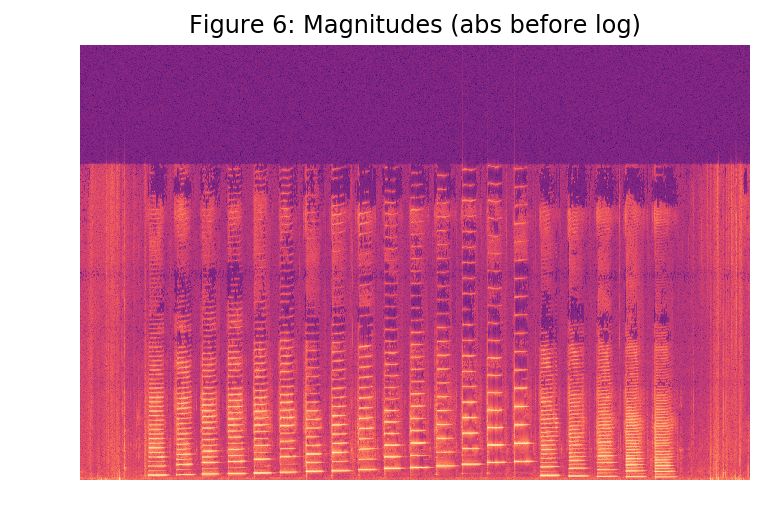

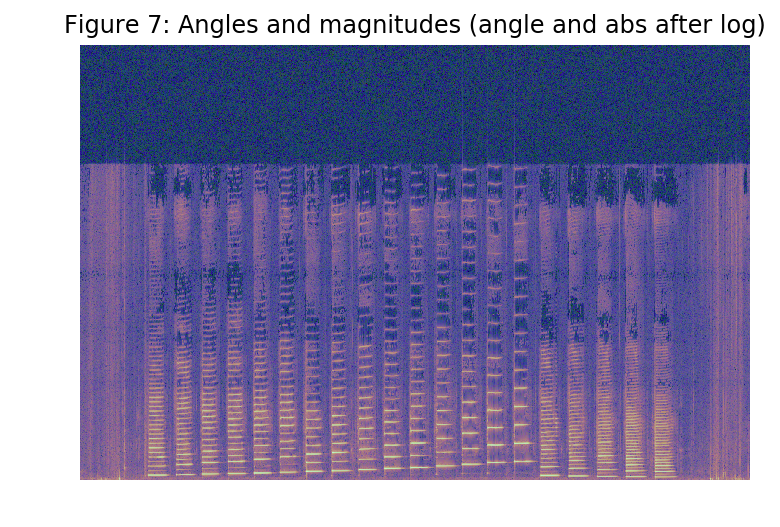

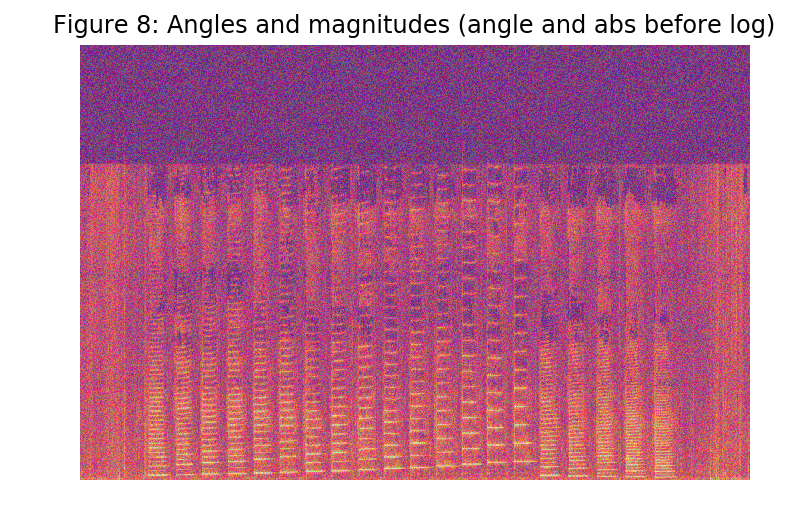

In [68]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Function from StackOverflow: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=5000):
    if type(cmap) is str:
        cmap = plt.get_cmap(cmap)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

print("Running")
sr, audio = wavfile.read('audio/homeFloor.wav')
audio = audio[:,0]
audio = audio.astype(np.float64)
print("Unpacked wav file")

spectrogram = librosa.stft(audio, 2048, 512)
angles = np.angle(spectrogram)
mags = np.log(np.abs(spectrogram))

plt.figure(0)
librosa.display.specshow(np.log(spectrogram))
plt.axis("off")
plt.title("Figure 1: Log-spectrogram (mags) via specshow")

plt.figure(1)
new_spectrogram = np.exp(mags) * np.exp(1j*angles)
librosa.display.specshow(np.log(new_spectrogram))
plt.title("Figure 2: New log-spectrogram (mags) via specshow")

#plt.figure(2)
#plt.imshow(np.angle(np.log(spectrogram)), cmap="hsv", origin="lower", aspect="auto")
#plt.axis("off")
#plt.title("Figure 3: Angles (angle after log)")

#plt.figure(3)
#plt.imshow(np.abs(np.log(spectrogram)), cmap="magma", origin="lower", aspect="auto")
#plt.axis("off")
#plt.title("Figure 4: Magnitudes (abs after log)")

plt.figure(4)
plt.imshow(angles, cmap="hsv", origin="lower", aspect="auto")
plt.axis("off")
plt.title("Figure 5: Angles (angle before log)")

plt.figure(5)
plt.imshow(np.log(np.abs(spectrogram)), cmap="magma", origin="lower", aspect="auto")
plt.axis("off")
plt.title("Figure 6: Magnitudes (abs before log)")

# Uses pcolormesh instead of imshow
# plt.figure(3)
# plt.pcolormesh(angles, zorder=1, cmap="binary")
# plt.pcolormesh(mags, zorder=2, alpha=0.05, cmap="inferno")
# plt.axis("off")
# plt.title("Angles and magnitudes")

plt.figure(6)
plt.imshow(np.angle(np.log(spectrogram)), zorder=1, cmap="hsv", origin="lower", aspect="auto")
plt.imshow(np.abs(np.log(spectrogram)), zorder=2, alpha=0.75, cmap="magma", origin="lower", aspect="auto")
plt.axis("off")
plt.title("Figure 7: Angles and magnitudes (angle and abs after log)")

plt.figure(7)
plt.imshow(angles, zorder=1, cmap="hsv", origin="lower", aspect="auto")
plt.imshow(mags, zorder=2, alpha=0.75, cmap="magma", origin="lower", aspect="auto")
plt.axis("off")
plt.title("Figure 8: Angles and magnitudes (angle and abs before log)")

new_audio = librosa.istft(new_spectrogram, 512)
new_audio_no_angles = librosa.istft(mags, 512)

# Plays the audio before and after the spectrogram making/inversion
# playAudio(audio[10*sr:15*sr], sr)
# playAudio(new_audio[10*sr:15*sr], sr)
# playAudio(new_audio_no_angles[10*sr:15*sr], sr)